<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I2wUTT12p5bX3RCku_T_82aD4tkY9LVY" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов.

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>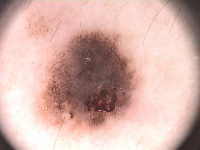</td><td>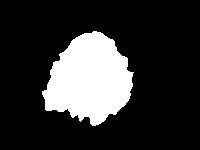</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

Для обучения CNN использовал ресурсы kaggle, соответственно не загружал данные с kaggle на colab. 

In [6]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"username","key":"api-key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d kanametov/ph2dataset

Dataset URL: https://www.kaggle.com/datasets/kanametov/ph2dataset
License(s): unknown
 91%|████████████████████████████████████▌   | 185M/203M [00:02<00:00, 52.1MB/s]
100%|████████████████████████████████████████| 203M/203M [00:02<00:00, 72.7MB/s]


In [8]:
!unzip -q ph2dataset.zip

In [9]:
!ls

PH2Dataset  ph2dataset.zip


Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [10]:
from skimage.io import imread
import glob
import os

root = 'PH2Dataset/PH2_Dataset/'

images = []
lesions = []

image_pattern = os.path.join(root, '*', '*_Dermoscopic_Image', '*.bmp')
lesion_pattern = os.path.join(root, '*', '*_lesion', '*.bmp')

image_files = glob.glob(image_pattern)
lesion_files = glob.glob(lesion_pattern)

for image_file, lesion_file in zip(image_files, lesion_files):
    images.append(imread(image_file))
    lesions.append(imread(lesion_file))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [11]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [12]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [13]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

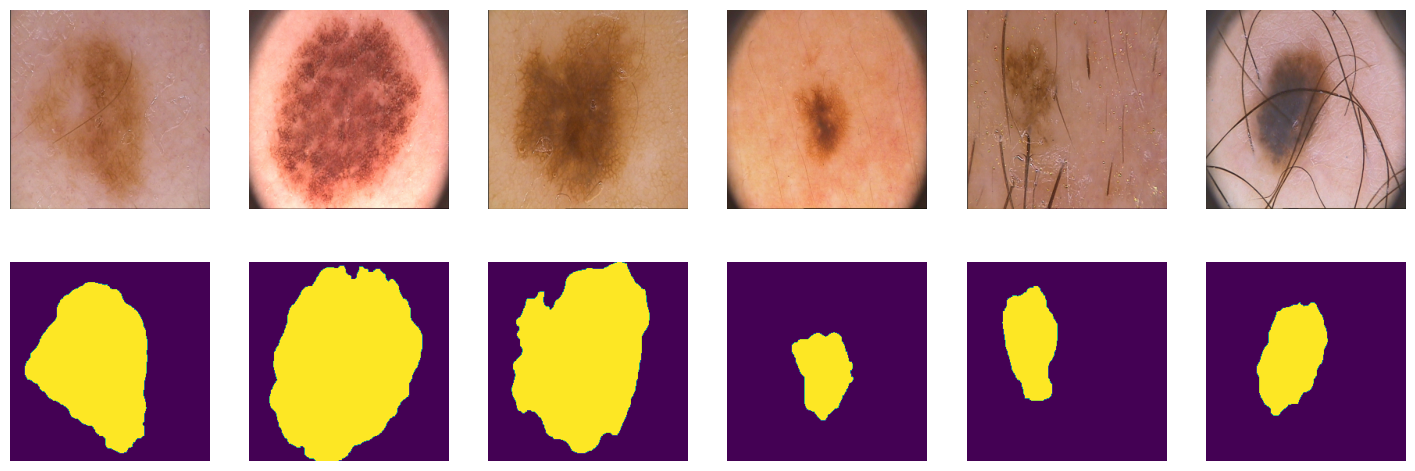

In [14]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [15]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [16]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [17]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [18]:
import torch

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

CUDA is available!  Training on GPU ...
cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

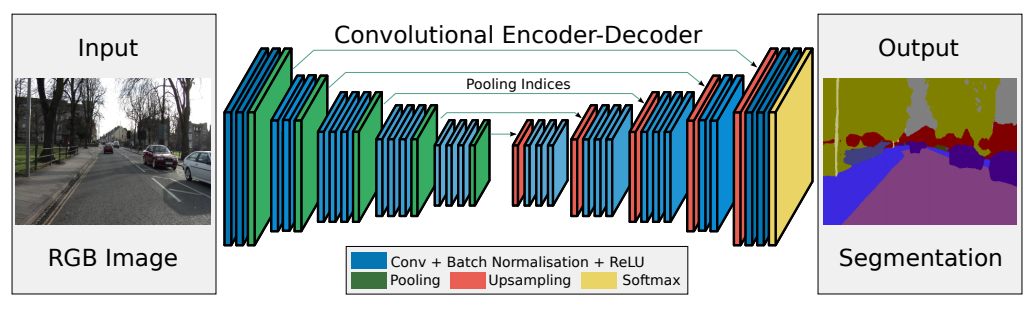

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [20]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 256 -> 128
        )
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)# 128 -> 64
        )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        )
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16
        )
        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 16 -> 8
        )    
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2),  
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )
        # decoder (upsampling)
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()   
        )
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()  
        )
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1))
    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(e0)
        e2 = self.enc_conv2(e1)
        e3 = self.enc_conv3(e2)
        e4 = self.enc_conv4(e3)
        # bottleneck
        b = self.bottleneck_conv(e4)
        # decoder
        d0 = self.dec_conv0(b+e3)
        d1 = self.dec_conv1(d0+e2)
        d2 = self.dec_conv2(d1+e1)
        d3 = self.dec_conv3(d2+e0)
        
        return d3

In [21]:
!pip install torch-summary
from torchsummary import summary

In [22]:
summary(SegNet(), (3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 128, 128]        --
|    └─Conv2d: 2-1                       [-1, 64, 256, 256]        1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 256, 256]        128
|    └─Conv2d: 2-3                       [-1, 64, 256, 256]        36,928
|    └─BatchNorm2d: 2-4                  [-1, 64, 256, 256]        128
|    └─ReLU: 2-5                         [-1, 64, 256, 256]        --
|    └─MaxPool2d: 2-6                    [-1, 64, 128, 128]        --
├─Sequential: 1-2                        [-1, 128, 64, 64]         --
|    └─Conv2d: 2-7                       [-1, 128, 128, 128]       73,856
|    └─BatchNorm2d: 2-8                  [-1, 128, 128, 128]       256
|    └─ReLU: 2-9                         [-1, 128, 128, 128]       --
|    └─Conv2d: 2-10                      [-1, 128, 128, 128]       147,584
|    └─BatchNorm2d: 2-11                 [-1, 128, 128, 128]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 128, 128]        --
|    └─Conv2d: 2-1                       [-1, 64, 256, 256]        1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 256, 256]        128
|    └─Conv2d: 2-3                       [-1, 64, 256, 256]        36,928
|    └─BatchNorm2d: 2-4                  [-1, 64, 256, 256]        128
|    └─ReLU: 2-5                         [-1, 64, 256, 256]        --
|    └─MaxPool2d: 2-6                    [-1, 64, 128, 128]        --
├─Sequential: 1-2                        [-1, 128, 64, 64]         --
|    └─Conv2d: 2-7                       [-1, 128, 128, 128]       73,856
|    └─BatchNorm2d: 2-8                  [-1, 128, 128, 128]       256
|    └─ReLU: 2-9                         [-1, 128, 128, 128]       --
|    └─Conv2d: 2-10                      [-1, 128, 128, 128]       147,584
|    └─BatchNorm2d: 2-11                 [-1, 128, 128, 128]      

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [23]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [24]:
def bce_loss(y_real, y_pred):
    return (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))).mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [25]:
def train(model, model_name, loss_name, opt, loss_fn, epochs, data_tr, data_val, scheduler=None, plot=False, images=False):
    history = {'epoch':[],'train_loss':[],'val_loss':[],'train_score':[], 'val_score':[]}
    X_val, Y_val = next(iter(data_val))
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        avg_score = 0
        model.train()  # train mode
        for X_batch, Y_batch in tqdm(data_tr):
            # data to device
            X_batch = X_batch.cuda()
            Y_batch = Y_batch.cuda()
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step() # update weights  
            # calculate loss, score to show the user
            avg_loss += loss / len(data_tr)
            avg_score += iou_pytorch(Y_batch, Y_pred > 0.5).mean() / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        
        if scheduler is not None:
            scheduler.step(avg_loss)
            
        # show intermediate results
        model.eval()
        Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu
        val_score = iou_pytorch(Y_val, Y_hat > 0.5).mean()
        val_loss = loss_fn(Y_val, Y_hat)

        history['epoch'].append(epoch)
        history['train_loss'].append(avg_loss.item())
        history['val_loss'].append(val_loss.item())
        history['val_score'].append(val_score.item())
        history['train_score'].append(avg_score.item())
        # Visualize tools
        clear_output(wait=True)
        if images == True:
            for k in range(6):
                plt.subplot(2, 6, k+1)
                plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')

                plt.subplot(2, 6, k+7)
                plt.imshow(Y_hat[k, 0], cmap='gray')
                plt.title('Output')
                plt.axis('off')
            plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
            plt.show()
    
    if plot == True:
        plot_history(history, model_name, loss_name)
    
    return history

In [26]:
def plot_history(history, model_name, loss_name):
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    axes[0].plot(history['epoch'], history['train_loss'], label='train_loss')
    axes[0].plot(history['epoch'], history['val_loss'], label='val_loss', color="green")
    axes[0].set_xlabel('Epoch', fontsize = 16)
    axes[0].set_ylabel('Loss', fontsize = 14) 
    axes[0].set_yticks(np.arange(0, 1, 0.05))
    
    axes[1].plot(history['epoch'], history['train_score'], label='train_score')
    axes[1].plot(history['epoch'], history['val_score'], label='val_score', color="green")
    axes[1].set_xlabel('Epoch', fontsize = 14)
    axes[1].set_yticks(np.arange(0, 1, 0.05))
    axes[1].set_ylabel('IoU', fontsize = 14)  
    for i in [0,1]: axes[i].legend()
    plt.suptitle(f"Model: {model_name}, loss: {loss_name}", fontsize = 20, y=1)
    plt.tight_layout()
    plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [27]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [28]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = (model(X_batch.to(device)) > 0.5).int()
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.optim import lr_scheduler
import torch.optim as optim
from time import time
from tqdm.notebook import tqdm
import gc

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

from collections import OrderedDict
import seaborn as sns

In [30]:
gc.collect()
torch.cuda.empty_cache()

Обучимся на 70 эпохах 

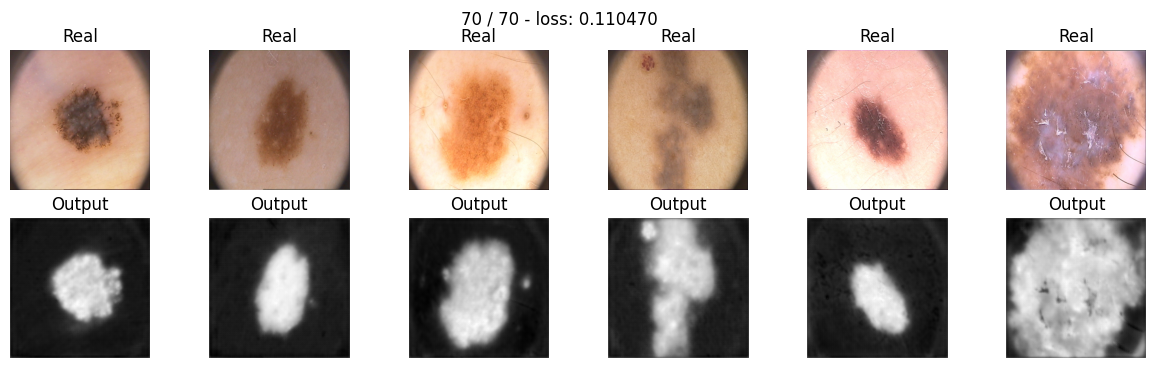

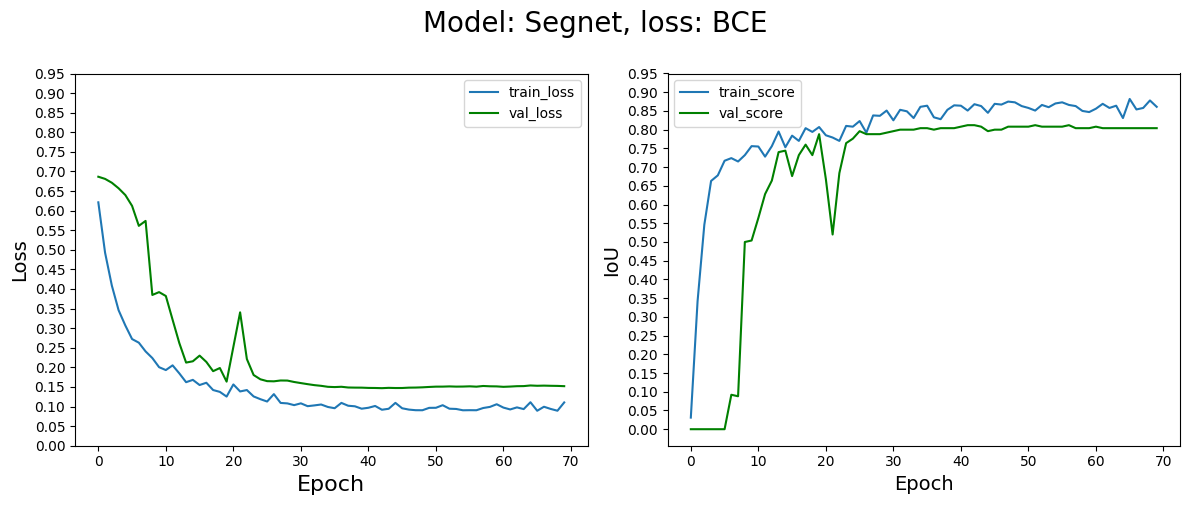

In [31]:
model = SegNet().to(device)
max_epochs = 70
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
#Reduces learning rate when a metric has stopped improving:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
    optim,
    patience=3,# for 3 epochs
    threshold=1e-4,
    mode="min"
)
history_segnet_bce = train(model, 'Segnet', 'BCE', optim, bce_loss, max_epochs, data_tr, data_val, scheduler, True, True)

In [32]:
Segnet_bce_score = score_model(model, iou_pytorch, data_val)
Segnet_bce_score

0.7559999823570251

**Видим, что модель ведет себя не очень стабильно, примерно, до 20 эпохи После 20 эпохи резко достигает "обратного" пика (понижения точности и увеличения loss) на валидации, потом выходит на стабильное плато вплоть до 70 эпохи. Признаков явного оверфиттинга нет, имхо**

In [33]:
import pandas as pd
results = pd.DataFrame({'model': [], 'loss': [], 'IoU val_score': []})
results.loc[-1] = ['Segnet', 'BCE', Segnet_bce_score]
results = results.reset_index(drop=True)
results

,model,loss,IoU val_score
0,Segnet,BCE,0.756


In [92]:
gc.collect()
torch.cuda.empty_cache()

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [34]:
def dice_loss(y_real, y_pred):
    smooth = 1e-5
    num = (torch.sigmoid(y_pred)).view(-1)
    den =  y_real.view(-1)
    intersection = torch.sum(num * den)
    union = torch.sum(num) + torch.sum(den)
    res = 1 - (2. * intersection + smooth) / (union + smooth)
    return res

Проводим тестирование:

In [35]:
model_dice = SegNet().to(device)

max_epochs = 70
optim = torch.optim.Adam(model_dice.parameters(), lr=1e-4)
#Reduces learning rate when a metric has stopped improving:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
    optim,
    patience=3,# for 3 epochs
    threshold=1e-4,
    mode="min"
)
history_segnet_dice = train(model_dice, 'Segnet', 'Dice coef.', optim, dice_loss, max_epochs, data_tr, data_val, scheduler)

* Epoch 70/70


  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.062338


In [36]:
Segnet_dice_score = score_model(model_dice, iou_pytorch, data_val)
Segnet_dice_score

0.7660000622272491

In [37]:
results.loc[-1] = ['Segnet', 'DICE', Segnet_dice_score]
results = results.reset_index(drop=True)
results

,model,loss,IoU val_score
0,Segnet,BCE,0.756
1,Segnet,DICE,0.766


In [39]:
gc.collect()
torch.cuda.empty_cache()

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [40]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.sigmoid(y_pred) + eps
   # y_pred = torch.sigmoid(torch.clamp(y_pred, eps, 1.0 - eps))
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    focal_loss = -((1 - y_pred) ** gamma * y_real * y_pred.log() + (1-y_real)*(1-y_pred).log())
    return focal_loss.mean()

In [41]:
model_focal = SegNet().to(device)
max_epochs = 70
optim = torch.optim.Adam(model_focal.parameters(), lr=1e-4)
#Reduces learning rate when a metric has stopped improving:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
    optim,
    patience=3,# for 3 epochs
    threshold=1e-4,
    mode="min"
)
history_segnet_focal = train(model_focal, 'Segnet', 'Focal loss.', optim, focal_loss, max_epochs, data_tr, data_val, scheduler)

* Epoch 70/70


  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.058873


In [42]:
Segnet_focal_score = score_model(model_focal, iou_pytorch, data_val)
Segnet_focal_score

0.7339999973773956

In [43]:
results.loc[-1] = ['Segnet', 'Focal', Segnet_focal_score]
results = results.reset_index(drop=True)
results

,model,loss,IoU val_score
0,Segnet,BCE,0.756
1,Segnet,DICE,0.766
2,Segnet,Focal,0.734


In [44]:
gc.collect()
torch.cuda.empty_cache()

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

**Попытаемся имплементировать SSIM (structure similarity), который является одним из методов измерения схожести между двумя изображениями**. 

Отличительной особенностью метода является то, что метод учитывает «восприятие ошибки» благодаря учёту структурного изменения информации: пиксели имеют сильную взаимосвязь, особенно когда они близки пространственно. Данные зависимости несут важную информацию о структуре объектов и о сцене в целом, что важно в рамках решаемой нами задачи.

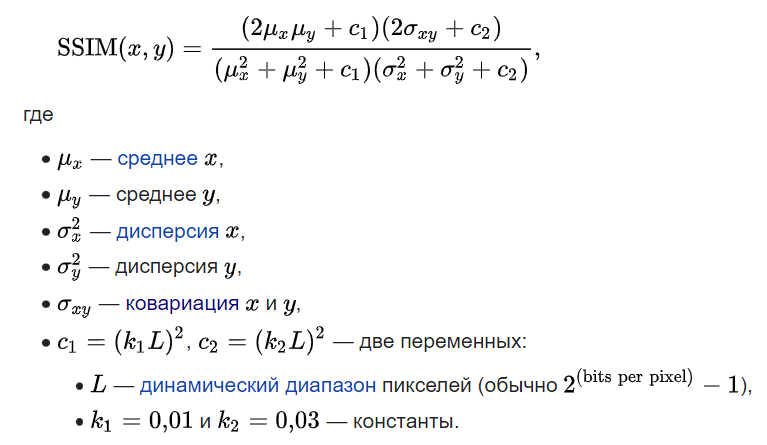

In [45]:
def ssim_loss(y_real, y_pred, C1=1e-4, C2=1e-6):
    x = y_real
    y = torch.sigmoid(y_pred)
    
    mean_x = torch.mean(x)
    mean_y = torch.mean(y)

    var_x = torch.var(x)
    var_y = torch.var(y)

    cov_xy = torch.mean((x - mean_x) * (y - mean_y))

    numerator = (2 * mean_x * mean_y + C1) * (2 * cov_xy + C2)
    denominator = (mean_x**2 + mean_y**2 + C1) * (var_x + var_y + C2)

    ssim = numerator / denominator

    return 1 - ssim

In [46]:
model_ssim = SegNet().to(device)
max_epochs = 70
optim = torch.optim.Adam(model_ssim.parameters(), lr=1e-4)
#Reduces learning rate when a metric has stopped improving:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
    optim,
    patience=3,# for 3 epochs
    threshold=1e-4,
    mode="min"
)
history_segnet_ssim = train(model_ssim, 'Segnet', 'SSIM loss.', optim, ssim_loss, max_epochs, data_tr, data_val, scheduler)

* Epoch 70/70


  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.051158


In [47]:
Segnet_ssim_score = score_model(model_ssim, iou_pytorch, data_val)
Segnet_ssim_score

0.7580000162124634

In [48]:
results.loc[-1] = ['Segnet', 'SSIM', Segnet_ssim_score]
results = results.reset_index(drop=True)
results

,model,loss,IoU val_score
0,Segnet,BCE,0.756
1,Segnet,DICE,0.766
2,Segnet,Focal,0.734
3,Segnet,SSIM,0.758


In [50]:
gc.collect()
torch.cuda.empty_cache()

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

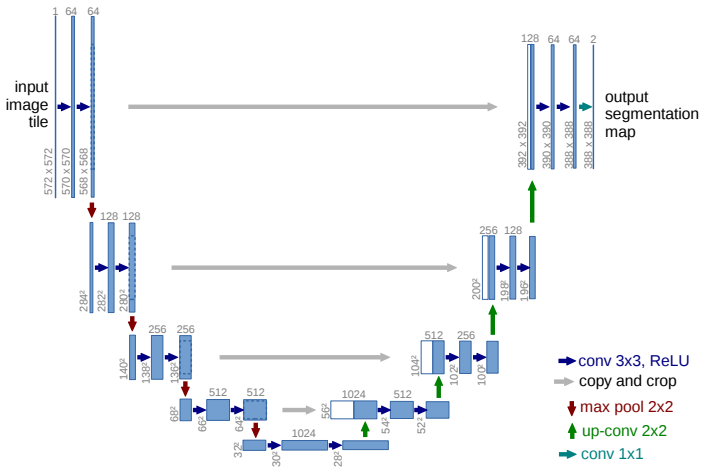

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [51]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool0 =  nn.MaxPool2d(kernel_size=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2)# 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2)# 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)# 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)# 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1),
            )
    def forward(self, x):
        # encoder
        enc0 = self.enc_conv0(x)
        pool0, indices_e0 = self.pool0(enc0)
        enc1 = self.enc_conv1(pool0)
        pool1, indices_e1 = self.pool1(enc1)
        enc2 = self.enc_conv2(pool1)
        pool2, indices_e2 = self.pool2(enc2)
        enc3 = self.enc_conv3(pool2)
        pool3, indices_e3 = self.pool3(enc3)
        # bottleneck
        b = self.bottleneck_conv(pool3)
        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b, indices_e3), enc3), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0, indices_e2), enc2), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1, indices_e1), enc1), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2, indices_e0), enc0), dim=1))
        # no activation
        return d3

In [52]:
summary(UNet(), (3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 256, 256]        --
|    └─Conv2d: 2-1                       [-1, 64, 256, 256]        1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 256, 256]        128
|    └─ReLU: 2-3                         [-1, 64, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 64, 256, 256]        36,928
|    └─BatchNorm2d: 2-5                  [-1, 64, 256, 256]        128
|    └─ReLU: 2-6                         [-1, 64, 256, 256]        --
├─MaxPool2d: 1-2                         [-1, 64, 128, 128]        --
├─Sequential: 1-3                        [-1, 128, 128, 128]       --
|    └─Conv2d: 2-7                       [-1, 128, 128, 128]       73,856
|    └─BatchNorm2d: 2-8                  [-1, 128, 128, 128]       256
|    └─ReLU: 2-9                         [-1, 128, 128, 128]       --
|    └─Conv2d: 2-10                      [-1, 128, 128, 128]       147,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 256, 256]        --
|    └─Conv2d: 2-1                       [-1, 64, 256, 256]        1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 256, 256]        128
|    └─ReLU: 2-3                         [-1, 64, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 64, 256, 256]        36,928
|    └─BatchNorm2d: 2-5                  [-1, 64, 256, 256]        128
|    └─ReLU: 2-6                         [-1, 64, 256, 256]        --
├─MaxPool2d: 1-2                         [-1, 64, 128, 128]        --
├─Sequential: 1-3                        [-1, 128, 128, 128]       --
|    └─Conv2d: 2-7                       [-1, 128, 128, 128]       73,856
|    └─BatchNorm2d: 2-8                  [-1, 128, 128, 128]       256
|    └─ReLU: 2-9                         [-1, 128, 128, 128]       --
|    └─Conv2d: 2-10                      [-1, 128, 128, 128]       147,

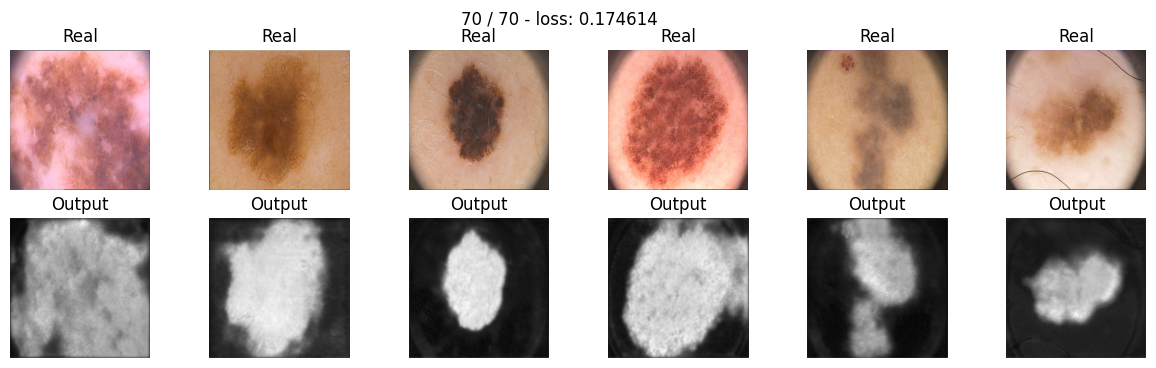

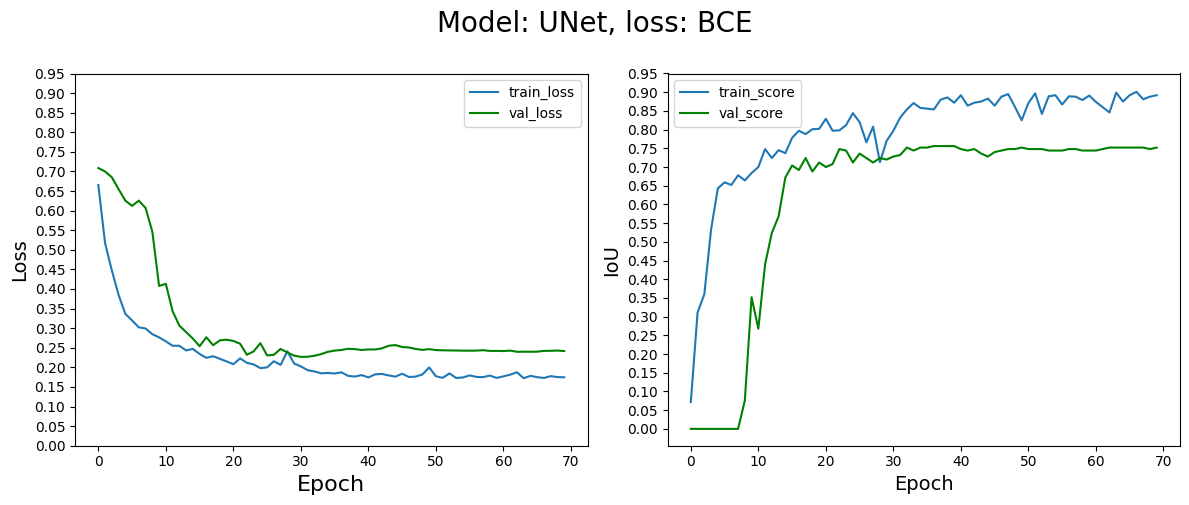

In [53]:
unet_model_bce = UNet().to(device)
max_epochs = 70
optim = torch.optim.Adam(unet_model_bce.parameters(), lr=1e-4)
#Reduces learning rate when a metric has stopped improving:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
    optim,
    patience=3,# for 3 epochs
    threshold=1e-4,
    mode="min")

history_unet_bce = train(unet_model_bce, 'UNet', 'BCE', optim, bce_loss, max_epochs, data_tr, data_val, scheduler, True, True)

In [54]:
UNet_bce_score = score_model(unet_model_bce, iou_pytorch, data_val)
UNet_bce_score

0.7519999742507935

In [55]:
results.loc[-1] = ['UNet', 'BCE', UNet_bce_score]
results = results.reset_index(drop=True)
results

,model,loss,IoU val_score
0,Segnet,BCE,0.756
1,Segnet,DICE,0.766
2,Segnet,Focal,0.734
3,Segnet,SSIM,0.758
4,UNet,BCE,0.752


In [56]:
gc.collect()
torch.cuda.empty_cache()

In [57]:
unet_model_dice = UNet().to(device)
max_epochs = 70
optim = torch.optim.Adam(unet_model_dice.parameters(), lr=1e-4)
#Reduces learning rate when a metric has stopped improving:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
    optim,
    patience=3,# for 3 epochs
    threshold=1e-4,
    mode="min")
history_unet_dice = train(unet_model_dice, 'UNet', 'dice', optim, dice_loss, max_epochs, data_tr, data_val, scheduler)

* Epoch 70/70


  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.191543


In [58]:
UNet_dice_score = score_model(unet_model_dice, iou_pytorch, data_val)
UNet_dice_score

0.7319999933242798

In [59]:
results.loc[-1] = ['UNet', 'Dice', UNet_dice_score]
results = results.reset_index(drop=True)
results

,model,loss,IoU val_score
0,Segnet,BCE,0.756
1,Segnet,DICE,0.766
2,Segnet,Focal,0.734
3,Segnet,SSIM,0.758
4,UNet,BCE,0.752
5,UNet,Dice,0.732


In [60]:
gc.collect()
torch.cuda.empty_cache()

In [61]:
unet_model_focal = UNet().to(device)
max_epochs = 70
optim = torch.optim.Adam(unet_model_focal.parameters(), lr=1e-4)
#Reduces learning rate when a metric has stopped improving:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
    optim,
    patience=3,# for 3 epochs
    threshold=1e-4,
    mode="min")
history_unet_focal = train(unet_model_focal, 'UNet', 'Focal loss', optim, focal_loss, max_epochs, data_tr, data_val, scheduler)

* Epoch 70/70


  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.082842


In [62]:
UNet_focal_score = score_model(unet_model_focal, iou_pytorch, data_val)
UNet_focal_score

0.7719999551773071

In [63]:
results.loc[-1] = ['UNet', 'Focal', UNet_focal_score]
results = results.reset_index(drop=True)
results

,model,loss,IoU val_score
0,Segnet,BCE,0.756
1,Segnet,DICE,0.766
2,Segnet,Focal,0.734
3,Segnet,SSIM,0.758
4,UNet,BCE,0.752
5,UNet,Dice,0.732
6,UNet,Focal,0.772


In [67]:
gc.collect()
torch.cuda.empty_cache()

In [68]:
unet_model_ssim = UNet().to(device)
max_epochs = 70
optim = torch.optim.Adam(unet_model_ssim.parameters(), lr=1e-4)
#Reduces learning rate when a metric has stopped improving:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
    optim,
    patience=3,# for 3 epochs
    threshold=1e-4,
    mode="min")
history_unet_ssim = train(unet_model_ssim, 'UNet', 'SSIM loss', optim, ssim_loss, max_epochs, data_tr, data_val, scheduler)

* Epoch 70/70


  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.167469


In [69]:
UNet_ssim_score = score_model(unet_model_ssim, iou_pytorch, data_val)
UNet_ssim_score

0.7339999973773956

In [70]:
results.loc[-1] = ['UNet', 'SSIM', UNet_ssim_score]
results = results.reset_index(drop=True)
results

,model,loss,IoU val_score
0,Segnet,BCE,0.756
1,Segnet,DICE,0.766
2,Segnet,Focal,0.734
3,Segnet,SSIM,0.758
4,UNet,BCE,0.752
5,UNet,Dice,0.732
6,UNet,Focal,0.772
7,UNet,SSIM,0.734


In [71]:
gc.collect()
torch.cuda.empty_cache()

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [73]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
                nn.Conv2d(3, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
            )
        self.enc_conv1 = nn.Sequential(
                nn.Conv2d(64, 128, 3, 2, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
            )
        self.enc_conv2 = nn.Sequential(
                nn.Conv2d(128, 256, 3, 2, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
            )
        self.enc_conv3 = nn.Sequential(
                nn.Conv2d(256, 512, 3, 2, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, 3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
            )
        
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                nn.Conv2d(512, 1024, 3, 2, padding=1),
                nn.BatchNorm2d(1024),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(1024, 512, 3, 2, padding=1, output_padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
            )

        # decoder (upsampling)
        self.dec_conv0 = nn.Sequential(
                nn.Conv2d(1024, 512, 3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(512, 256, 3, 2, padding=1, output_padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
            )
        self.dec_conv1 = nn.Sequential(
                nn.Conv2d(512, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(256, 128, 3, 2, padding=1, output_padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
            )
        self.dec_conv2 = nn.Sequential(
                nn.Conv2d(256, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(128, 64, 3, 2, padding=1, output_padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
            )
        self.dec_conv3 = nn.Sequential(
                nn.Conv2d(128, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 1, 1, padding=0),                
            )

    def forward(self, x):
        # encoder
        o0 = self.enc_conv0(x)
        o1 = self.enc_conv1(o0)
        o2 = self.enc_conv2(o1)
        o3 = self.enc_conv3(o2)
        
        # bottleneck
        b = self.bottleneck_conv(o3)

        # decoder
        d0 = self.dec_conv0(torch.cat([o3, b],1))
        d1 = self.dec_conv1(torch.cat([o2, d0],1))
        d2 = self.dec_conv2(torch.cat([o1, d1],1))
        d3 = self.dec_conv3(torch.cat([o0, d2],1))
        return d3

In [113]:
summary(UNet2(), (3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 256, 256]        --
|    └─Conv2d: 2-1                       [-1, 64, 256, 256]        1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 256, 256]        128
|    └─ReLU: 2-3                         [-1, 64, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 64, 256, 256]        36,928
|    └─BatchNorm2d: 2-5                  [-1, 64, 256, 256]        128
|    └─ReLU: 2-6                         [-1, 64, 256, 256]        --
├─Sequential: 1-2                        [-1, 128, 128, 128]       --
|    └─Conv2d: 2-7                       [-1, 128, 128, 128]       73,856
|    └─BatchNorm2d: 2-8                  [-1, 128, 128, 128]       256
|    └─ReLU: 2-9                         [-1, 128, 128, 128]       --
|    └─Conv2d: 2-10                      [-1, 128, 128, 128]       147,584
|    └─BatchNorm2d: 2-11                 [-1, 128, 128, 128]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 256, 256]        --
|    └─Conv2d: 2-1                       [-1, 64, 256, 256]        1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 256, 256]        128
|    └─ReLU: 2-3                         [-1, 64, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 64, 256, 256]        36,928
|    └─BatchNorm2d: 2-5                  [-1, 64, 256, 256]        128
|    └─ReLU: 2-6                         [-1, 64, 256, 256]        --
├─Sequential: 1-2                        [-1, 128, 128, 128]       --
|    └─Conv2d: 2-7                       [-1, 128, 128, 128]       73,856
|    └─BatchNorm2d: 2-8                  [-1, 128, 128, 128]       256
|    └─ReLU: 2-9                         [-1, 128, 128, 128]       --
|    └─Conv2d: 2-10                      [-1, 128, 128, 128]       147,584
|    └─BatchNorm2d: 2-11                 [-1, 128, 128, 128]      

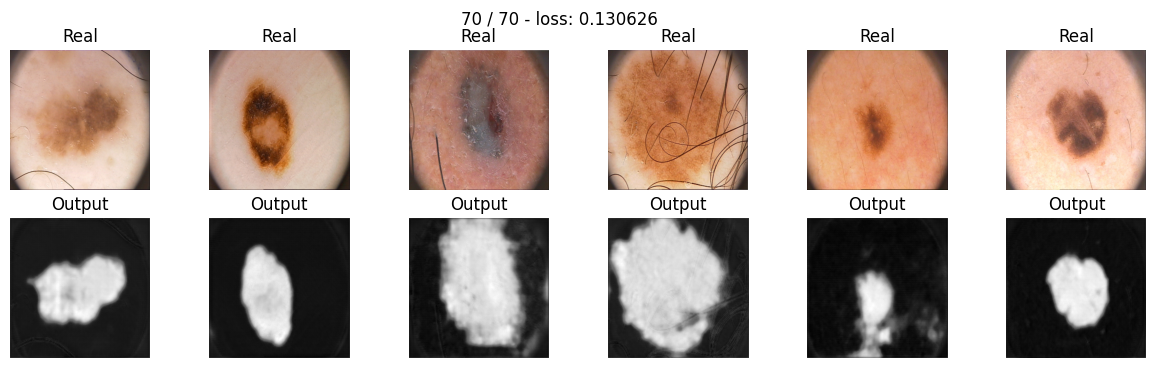

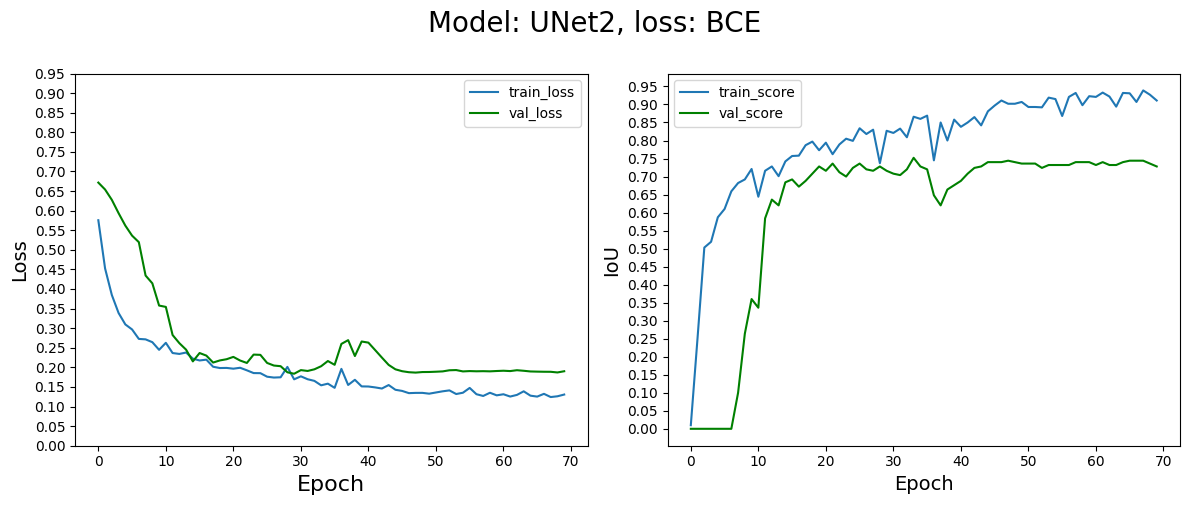

In [75]:
unet_model_2_bce = UNet2().to(device)
max_epochs = 70
optim = torch.optim.Adam(unet_model_2_bce.parameters(), lr=1e-4)
#Reduces learning rate when a metric has stopped improving:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
    optim,
    patience=3,# for 3 epochs
    threshold=1e-4,
    mode="min")

history_unet2_bce = train(unet_model_2_bce, 'UNet2', 'BCE', optim, bce_loss, max_epochs, data_tr, data_val, scheduler, True, True)

In [76]:
UNet2_bce_score = score_model(unet_model_2_bce, iou_pytorch, data_val)
UNet2_bce_score

0.7419999837875366

In [77]:
results.loc[-1] = ['UNet_2', 'BCE', UNet2_bce_score]
results = results.reset_index(drop=True)
results

,model,loss,IoU val_score
0,Segnet,BCE,0.756
1,Segnet,DICE,0.766
2,Segnet,Focal,0.734
3,Segnet,SSIM,0.758
4,UNet,BCE,0.752
5,UNet,Dice,0.732
6,UNet,Focal,0.772
7,UNet,SSIM,0.734
8,UNet_2,BCE,0.742


In [78]:
gc.collect()
torch.cuda.empty_cache()

In [79]:
unet_model_2_dice = UNet2().to(device)
max_epochs = 70
optim = torch.optim.Adam(unet_model_2_dice.parameters(), lr=1e-4)
#Reduces learning rate when a metric has stopped improving:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
    optim,
    patience=3,# for 3 epochs
    threshold=1e-4,
    mode="min")
history_unet2_dice = train(unet_model_2_dice, 'UNet', 'dice', optim, dice_loss, max_epochs, data_tr, data_val, scheduler)

* Epoch 70/70


  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.147449


In [80]:
UNet2_dice_score = score_model(unet_model_2_dice, iou_pytorch, data_val)
UNet2_dice_score

0.7339999973773956

In [81]:
results.loc[-1] = ['UNet_2', 'Dice', UNet2_dice_score]
results = results.reset_index(drop=True)
results

,model,loss,IoU val_score
0,Segnet,BCE,0.756
1,Segnet,DICE,0.766
2,Segnet,Focal,0.734
3,Segnet,SSIM,0.758
4,UNet,BCE,0.752
5,UNet,Dice,0.732
6,UNet,Focal,0.772
7,UNet,SSIM,0.734
8,UNet_2,BCE,0.742
9,UNet_2,Dice,0.734


In [82]:
gc.collect()
torch.cuda.empty_cache()

In [83]:
unet_model_2_focal = UNet2().to(device)
max_epochs = 70
optim = torch.optim.Adam(unet_model_2_focal.parameters(), lr=1e-4)
#Reduces learning rate when a metric has stopped improving:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
    optim,
    patience=3,# for 3 epochs
    threshold=1e-4,
    mode="min")
history_unet2_focal = train(unet_model_2_focal, 'UNet', 'Focal loss', optim, focal_loss, max_epochs, data_tr, data_val, scheduler)

* Epoch 70/70


  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.087186


In [84]:
UNet2_focal_score = score_model(unet_model_2_focal, iou_pytorch, data_val)
UNet2_focal_score

0.7180000245571136

In [85]:
results.loc[-1] = ['UNet_2', 'Focal', UNet2_focal_score]
results = results.reset_index(drop=True)
results

,model,loss,IoU val_score
0,Segnet,BCE,0.756
1,Segnet,DICE,0.766
2,Segnet,Focal,0.734
3,Segnet,SSIM,0.758
4,UNet,BCE,0.752
5,UNet,Dice,0.732
6,UNet,Focal,0.772
7,UNet,SSIM,0.734
8,UNet_2,BCE,0.742
9,UNet_2,Dice,0.734


In [86]:
gc.collect()
torch.cuda.empty_cache()

In [87]:
unet_model_2_ssim = UNet2().to(device)
max_epochs = 70
optim = torch.optim.Adam(unet_model_2_ssim.parameters(), lr=1e-4)
#Reduces learning rate when a metric has stopped improving:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
    optim,
    patience=3,# for 3 epochs
    threshold=1e-4,
    mode="min")
history_unet2_ssim = train(unet_model_2_ssim, 'UNet', 'SSIM loss', optim, ssim_loss, max_epochs, data_tr, data_val, scheduler)

* Epoch 70/70


  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.133947


In [88]:
UNet2_ssim_score = score_model(unet_model_2_ssim, iou_pytorch, data_val)
UNet2_ssim_score

0.7420000433921814

In [89]:
results.loc[-1] = ['UNet_2', 'SSIM', UNet2_ssim_score]
results = results.reset_index(drop=True)
results

,model,loss,IoU val_score
0,Segnet,BCE,0.756
1,Segnet,DICE,0.766
2,Segnet,Focal,0.734
3,Segnet,SSIM,0.758
4,UNet,BCE,0.752
5,UNet,Dice,0.732
6,UNet,Focal,0.772
7,UNet,SSIM,0.734
8,UNet_2,BCE,0.742
9,UNet_2,Dice,0.734


Выводы по моделям представлены ниже, в отчете.

# Отчет (6 баллов):
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте.
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии:

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

## Анализ графиков лоссов и метрик на валидации

### Segnet

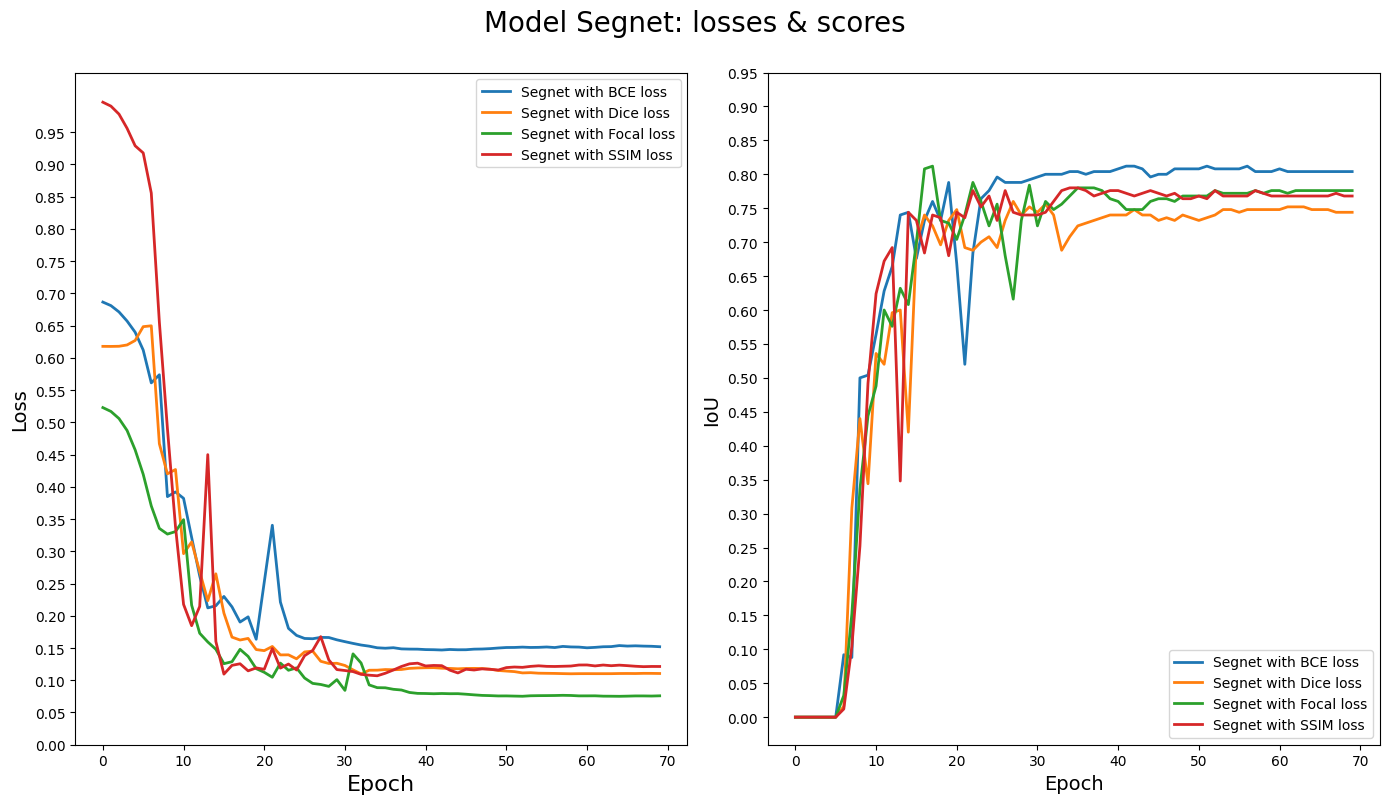

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(14,8))
axes[0].plot(range(max_epochs), history_segnet_bce['val_loss'], label="Segnet with BCE loss", linewidth=2)
axes[0].plot(range(max_epochs), history_segnet_dice['val_loss'], label="Segnet with Dice loss", linewidth=2)
axes[0].plot(range(max_epochs), history_segnet_focal['val_loss'], label="Segnet with Focal loss", linewidth=2)
axes[0].plot(range(max_epochs), history_segnet_ssim['val_loss'], label="Segnet with SSIM loss", linewidth=2)

axes[0].set_xlabel('Epoch', fontsize = 16)
axes[0].set_ylabel('Loss', fontsize = 14) 
axes[0].set_yticks(np.arange(0, 1, 0.05))

axes[1].plot(range(max_epochs), history_segnet_bce['val_score'], label="Segnet with BCE loss", linewidth=2)
axes[1].plot(range(max_epochs), history_segnet_dice['val_score'], label="Segnet with Dice loss", linewidth=2)
axes[1].plot(range(max_epochs), history_segnet_focal['val_score'], label="Segnet with Focal loss", linewidth=2)
axes[1].plot(range(max_epochs), history_segnet_ssim['val_score'], label="Segnet with SSIM loss", linewidth=2)

axes[1].set_xlabel('Epoch', fontsize = 14)
axes[1].set_yticks(np.arange(0, 1, 0.05))
axes[1].set_ylabel('IoU', fontsize = 14) 

for i in [0,1]: axes[i].legend()
    
plt.suptitle("Model Segnet: losses & scores", fontsize = 20, y=1)
plt.tight_layout()
plt.show()

С одной стороны, видим, что модель с focal loss имеет наименьшее значение loss, выходя на плато, начиная с 30+ эпохи. Также модель с bce, начиная с 20+ эпохи вырывается вперед по score. Однако модели с dice loss и SSIM loss при обучении ведут себя более стабильно.   

### UNet

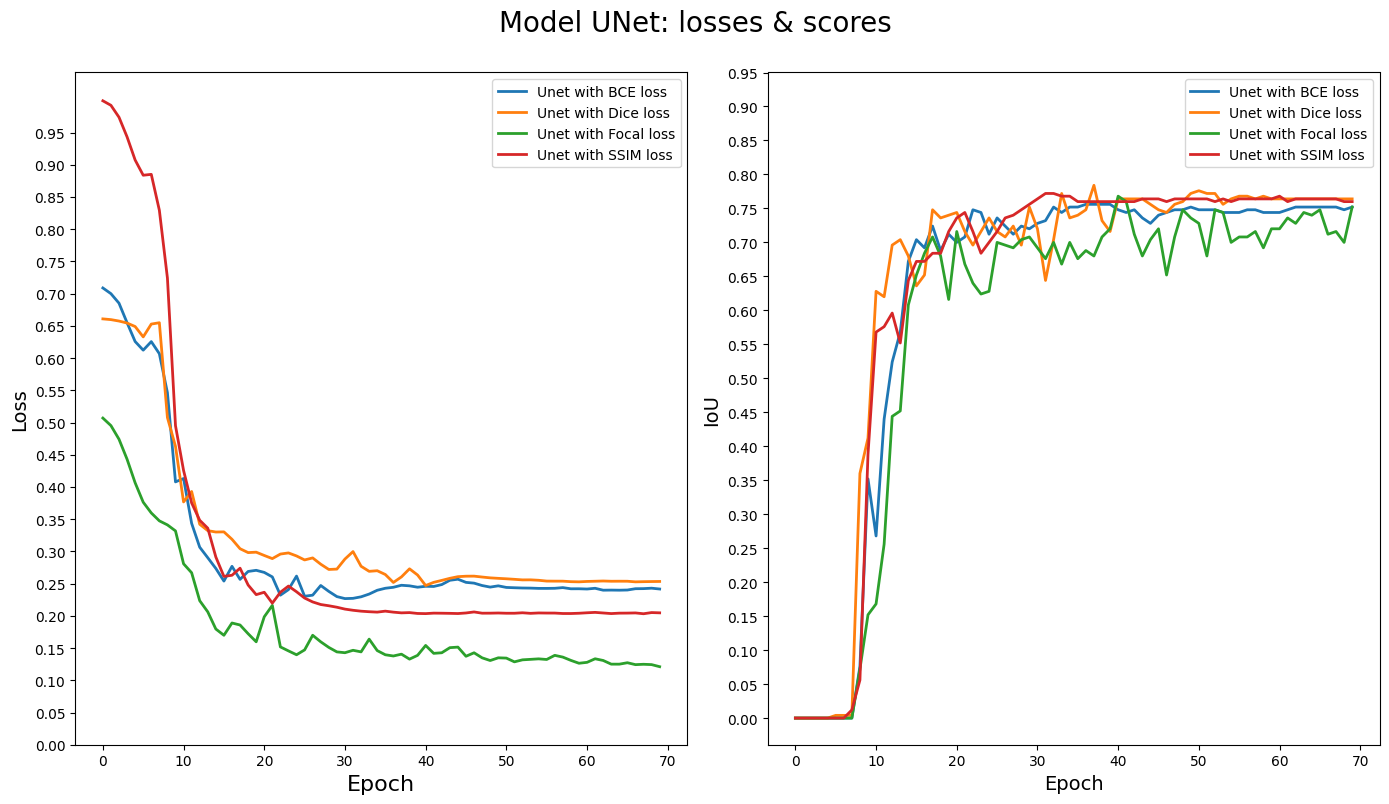

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(14,8))
axes[0].plot(range(max_epochs), history_unet_bce['val_loss'], label="Unet with BCE loss", linewidth=2)
axes[0].plot(range(max_epochs), history_unet_dice['val_loss'], label="Unet with Dice loss", linewidth=2)
axes[0].plot(range(max_epochs), history_unet_focal['val_loss'], label="Unet with Focal loss", linewidth=2)
axes[0].plot(range(max_epochs), history_unet_ssim['val_loss'], label="Unet with SSIM loss", linewidth=2)

axes[0].set_xlabel('Epoch', fontsize = 16)
axes[0].set_ylabel('Loss', fontsize = 14) 
axes[0].set_yticks(np.arange(0, 1, 0.05))

axes[1].plot(range(max_epochs), history_unet_bce['val_score'], label="Unet with BCE loss", linewidth=2)
axes[1].plot(range(max_epochs), history_unet_dice['val_score'], label="Unet with Dice loss", linewidth=2)
axes[1].plot(range(max_epochs), history_unet_focal['val_score'], label="Unet with Focal loss", linewidth=2)
axes[1].plot(range(max_epochs), history_unet_ssim['val_score'], label="Unet with SSIM loss", linewidth=2)

axes[1].set_xlabel('Epoch', fontsize = 14)
axes[1].set_yticks(np.arange(0, 1, 0.05))
axes[1].set_ylabel('IoU', fontsize = 14) 

for i in [0,1]: axes[i].legend()
    
plt.suptitle("Model UNet: losses & scores", fontsize = 20, y=1)
plt.tight_layout()
plt.show()

Здесь видим, что обучение на первых 20 эпохах идет более плавно по сравнению с Segnet. На последних 30 эпохах конкуренция идет, главным образом, между моделями с dice loss и SSIM loss, при этом первой модели, исходя из графиков, я бы отдал предпочтение. Модель с focal loss ведет себя очень нестабильно, нужно отметить резкий восходящий тренд в конце обучения: возможно, требуется большее количество эпох.

### UNet2

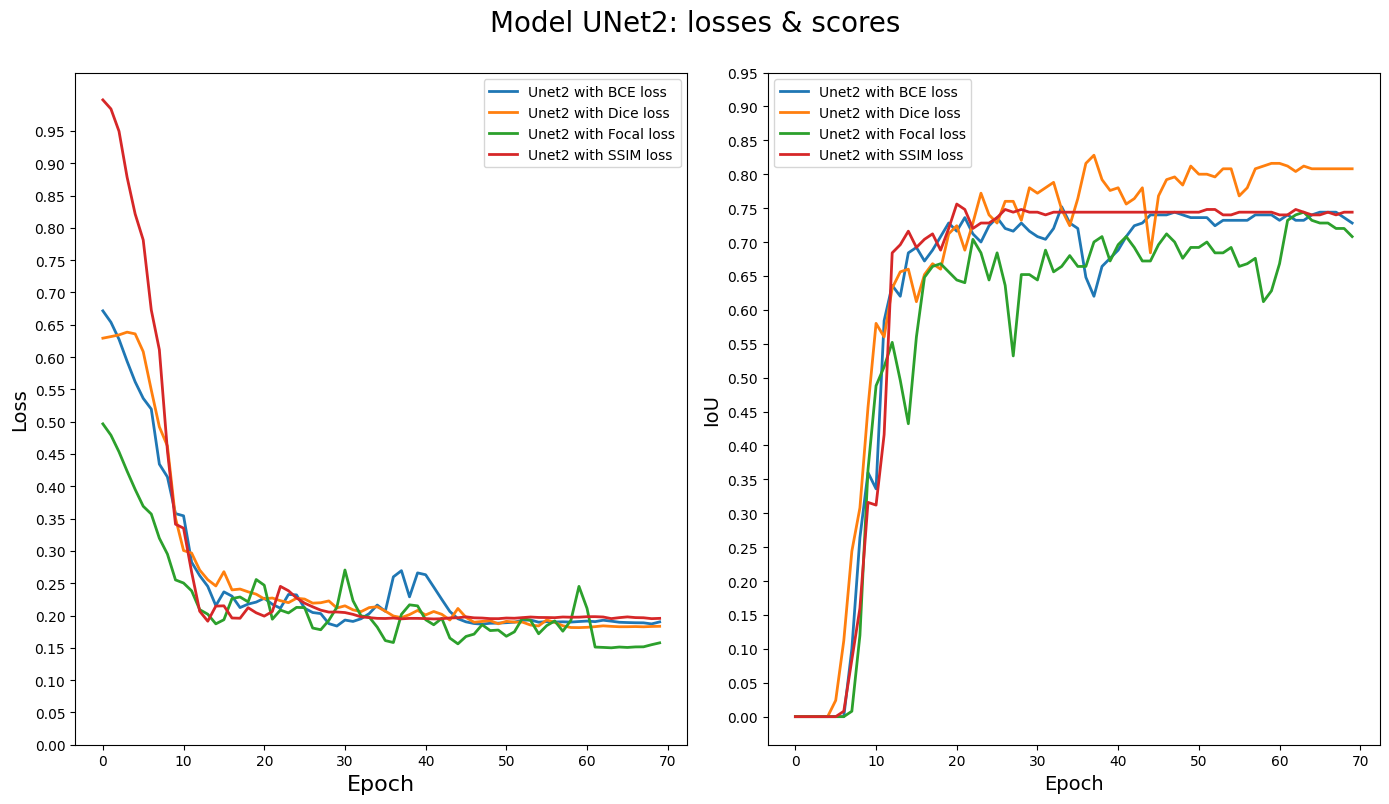

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(14,8))
axes[0].plot(range(max_epochs), history_unet2_bce['val_loss'], label="Unet2 with BCE loss", linewidth=2)
axes[0].plot(range(max_epochs), history_unet2_dice['val_loss'], label="Unet2 with Dice loss", linewidth=2)
axes[0].plot(range(max_epochs), history_unet2_focal['val_loss'], label="Unet2 with Focal loss", linewidth=2)
axes[0].plot(range(max_epochs), history_unet2_ssim['val_loss'], label="Unet2 with SSIM loss", linewidth=2)

axes[0].set_xlabel('Epoch', fontsize = 16)
axes[0].set_ylabel('Loss', fontsize = 14) 
axes[0].set_yticks(np.arange(0, 1, 0.05))

axes[1].plot(range(max_epochs), history_unet2_bce['val_score'], label="Unet2 with BCE loss", linewidth=2)
axes[1].plot(range(max_epochs), history_unet2_dice['val_score'], label="Unet2 with Dice loss", linewidth=2)
axes[1].plot(range(max_epochs), history_unet2_focal['val_score'], label="Unet2 with Focal loss", linewidth=2)
axes[1].plot(range(max_epochs), history_unet2_ssim['val_score'], label="Unet2 with SSIM loss", linewidth=2)

axes[1].set_xlabel('Epoch', fontsize = 14)
axes[1].set_yticks(np.arange(0, 1, 0.05))
axes[1].set_ylabel('IoU', fontsize = 14) 

for i in [0,1]: axes[i].legend()
    
plt.suptitle("Model UNet2: losses & scores", fontsize = 20, y=1)
plt.tight_layout()
plt.show()

Здесь видим, что явным лидером явлется модель с dice loss. При этом результаты хуже по сравнению с UNet. Модели с архитектурой Unet2, в целом (кроме SSIM), ведут себя более нестабильно при обучении. Есть ощущение, что для более явной сходимости требуется большее количество эпох. Однако нужно отметить, что Unet2 "тяжелее" базовой архитектуры на 7 млн. параметров, что на бОльшем датасете может быть неоправданно "дорого". В данной задаче я бы остановился на базовой архитектуре, без транспонированных сверток.   

### Итоговые результаты на валидационной выборке 


In [117]:
results.sort_values(by=['IoU val_score'], ignore_index=True)

,model,loss,IoU val_score
0,UNet_2,Focal,0.718
1,UNet,Dice,0.732
2,UNet,SSIM,0.734
3,Segnet,Focal,0.734
4,UNet_2,Dice,0.734
5,UNet_2,BCE,0.742
6,UNet_2,SSIM,0.742
7,UNet,BCE,0.752
8,Segnet,BCE,0.756
9,Segnet,SSIM,0.758


### Итоговые результаты на тестовой выборке


In [129]:
segnet_bce_test_score = score_model(model, iou_pytorch, data_ts)
segnet_dice_test_score = score_model(model_dice, iou_pytorch, data_ts)
segnet_focal_test_score = score_model(model_focal, iou_pytorch, data_ts)
segnet_ssim_test_score = score_model(model_ssim, iou_pytorch, data_ts)

unet_bce_test_score = score_model(unet_model_bce, iou_pytorch, data_ts)
unet_dice_test_score = score_model(unet_model_dice, iou_pytorch, data_ts)
unet_focal_test_score = score_model(unet_model_focal, iou_pytorch, data_ts)
unet_ssim_test_score = score_model(unet_model_ssim, iou_pytorch, data_ts)

unet2_bce_test_score = score_model(unet_model_2_bce, iou_pytorch, data_ts)
unet2_dice_test_score = score_model(unet_model_2_dice, iou_pytorch, data_ts)
unet2_focal_test_score = score_model(unet_model_2_focal, iou_pytorch, data_ts)
unet2_ssim_test_score = score_model(unet_model_2_ssim, iou_pytorch, data_ts)

In [130]:
y = [segnet_bce_test_score, segnet_dice_test_score, segnet_focal_test_score, segnet_ssim_test_score,
     unet_bce_test_score, unet_dice_test_score, unet_focal_test_score, unet_ssim_test_score,
     unet2_bce_test_score, unet2_dice_test_score, unet2_focal_test_score, unet2_ssim_test_score]

x = ['segnet_bce', 'segnet_dice', 'segnet_focal', 'segnet_ssim',
     'unet_bce', 'unet_dice', 'unet_focal', 'unet_ssim',
     'unet2_bce', 'unet2_dice', 'unet2_focal', 'unet2_ssim']

In [131]:
data = []
data.append(x)
data.append(y)
df = pd.DataFrame(data).transpose()
df.columns = ['model', 'IoU test_score']
df.sort_values(by=['IoU test_score'], ignore_index=True)

,model,IoU test_score
0,unet2_focal,0.62
1,unet2_ssim,0.684
2,unet_focal,0.696
3,unet2_bce,0.712
4,segnet_focal,0.724
5,unet_ssim,0.726
6,unet_bce,0.73
7,unet2_dice,0.742
8,segnet_ssim,0.75
9,segnet_bce,0.75


**В результате тестирования обученных моделей выявлен победитель - это модель Segnet with dice loss.Данная модель, как показано выше, также была лучшей среди Segnet на валидации (2-й среди всех моделей). В целом, нужно отметить, что функция потерь dice loss оказалась наиболее эффективной для каждой из обученных моделей, независимо от архитектуры.**